# Classification 4

We are going to look at Decision Trees.

We will analyze the _Titanic_ dataset, containing features of the people on the Titanic, and whether they survived or not. Data can be found [here](http://biostat.mc.vanderbilt.edu/wiki/pub/Main/DataSets/titanic.txt).

We will use Decision Trees to answer super-important questions like:

**Will Leo di Caprio make it out alive?**

(Hint: Nah.)

In [1]:
from pandas import Series, DataFrame
import pandas as pd
from patsy import dmatrices
import warnings
%pylab inline
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


In [2]:
df = pd.read_csv('Classification_4_data/titanic.txt')
df.columns.values

array(['row.names', 'pclass', 'survived', 'name', 'age', 'embarked',
       'home.dest', 'room', 'ticket', 'boat', 'sex'], dtype=object)

How many passengers?

In [3]:
len(df)

1313

Show me one.

In [4]:
df.iloc[0]

row.names                               1
pclass                                1st
survived                                1
name         Allen, Miss Elisabeth Walton
age                                  29.0
embarked                      Southampton
home.dest                    St Louis, MO
room                                  B-5
ticket                         24160 L221
boat                                    2
sex                                female
Name: 0, dtype: object

In [5]:
df['embarked'].value_counts()

Southampton    573
Cherbourg      203
Queenstown      45
Name: embarked, dtype: int64

### Create the design matrices

In [13]:
Y, X = dmatrices('survived ~ 0 + C(pclass) + age + C(embarked) + sex', df, return_type='dataframe')
y = Y['survived'].values

In [14]:
X[:5]

,C(pclass)[1st],C(pclass)[2nd],C(pclass)[3rd],C(embarked)[T.Queenstown],C(embarked)[T.Southampton],sex[T.male],age
0,1.0,0.0,0.0,0.0,1.0,0.0,29.0000
1,1.0,0.0,0.0,0.0,1.0,0.0,2.0000
2,1.0,0.0,0.0,0.0,1.0,1.0,30.0000
3,1.0,0.0,0.0,0.0,1.0,0.0,25.0000
4,1.0,0.0,0.0,0.0,1.0,1.0,0.9167


In [15]:
df['pclass'].value_counts()

3rd    711
1st    322
2nd    280
Name: pclass, dtype: int64

### Split data into train and test

In [34]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

### Set up classifier

In [35]:
from sklearn import tree
model = tree.DecisionTreeClassifier(criterion='entropy')

### Fit the data

In [36]:
result = model.fit(X_train, y_train)

In [37]:
from sklearn import metrics

prediction_train = model.predict(X_train)
print(metrics.accuracy_score(y_train, prediction_train))

0.9246575342465754


### Accuracy on test set

In [38]:
prediction = model.predict(X_test)
print(metrics.accuracy_score(y_test, prediction))

0.7724867724867724


This is far worse than the 92% accuracy we expected from the training set. Clearly, we are **overfitting**.

One way to avoid overfitting is to ensure that trees never become too deep, via the *max\_depth* argument.

In [21]:
model2 = tree.DecisionTreeClassifier(criterion='entropy', max_depth=2)
result = model2.fit(X_train, y_train)

### Accuracy

In [22]:
prediction_train = model2.predict(X_train)
print(metrics.accuracy_score(y_train, prediction_train))

0.8287671232876712


In [23]:
prediction = model2.predict(X_test)
print(metrics.accuracy_score(y_test, prediction))

0.8095238095238095


### What does the tree look like?

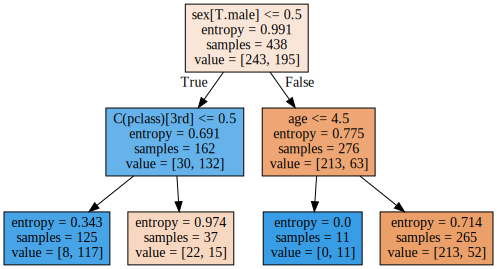

In [41]:
# Install the anaconda package "python-graphviz" (easier)
# Alternately, install "Graphviz" software, and the "pip install graphviz"
import graphviz
graphviz.Source(tree.export_graphviz(model2,
                                     out_file=None,
                                     feature_names=X.columns.values,
                                     filled=True))

* Each node of the decision tree checks a feature value
    * If the answer is _Yes_, take the left branch
    * else take the right branch.
* Root node in the tree checks if sex[T.male] <= 0.5. sex[T.male] is 1 if male and 0 if female, so it is less than 0.5 for females.
    * If _Yes_ (left branch), check if pclass[3rd] is 0, etc.
* A leaf node has _value_ (i.e., class label) as a list:
    * first item of list is class label 0 (negative class)
    * second list item is class label 1 (positive class)

    if sex=female:
        if not 3rd class passenger:
            return "likely survives: probability 117/125"
        else:
            return "likely dies: probability 22/37"
    else:
        if age <= 4.5 years (baby):
            return "always survives"
        else:
            return "likely dies: probability 52/265"

Note that even though port of embarkation was a feature, it was not discriminative enough to be included.

What did our first model (with possible overfitting) look like?

In [42]:
graphviz.Source(tree.export_graphviz(model,
                                     out_file=None,
                                     feature_names=X.columns.values,
                                     filled=True)).render('Classification_4_data/titanic1', format='png')

'Classification_4_data/titanic1.png'

![Titanic overfitting](Classification_4_data/titanic1.png)

Let us try decision trees on another problem: guessing the income level of an adult. We saw this problem earlier when we tried Naive Bayes.

In [43]:
names = ['age', 'workclass', 'fnlwgt', 'education', 'education_num', \
         'marital_status', 'occupation', 'relationship', 'race', 'sex', \
         'capital_gain', 'capital_loss', 'hours_per_week', \
         'native_country', 'income_band']
df = pd.read_table('Classification_2_data/adult.data', sep=', ', names=names)
df.iloc[0]

age                          39
workclass             State-gov
fnlwgt                    77516
education             Bachelors
education_num                13
marital_status    Never-married
occupation         Adm-clerical
relationship      Not-in-family
race                      White
sex                        Male
capital_gain               2174
capital_loss                  0
hours_per_week               40
native_country    United-States
income_band               <=50K
Name: 0, dtype: object

### Create the target

In [44]:
df['target'] = 0.0
mask = (df['income_band'] == '>50K')
df['target'][mask] = 1.0

### Create the design matrices

With Naive Bayes, we had to properly bin the data (e.g., hours worked, capital gains, etc.) A decision tree should be able to figure out the right split thresholds by itself.

In [45]:
formula = 'target ~ 0 + age + workclass + fnlwgt + education + education_num + ' + \
          'marital_status + occupation + relationship + race + sex + ' \
          'capital_gain + capital_loss + hours_per_week'
Y, X = dmatrices(formula, df, return_type='dataframe')
y = Y['target'].values

### Split intro training and testing sets

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

### Set up the classifier

We saw that getting the right _max\_depth_ was important to avoid overfitting. Let us try cross-validation for this.

In [51]:
from sklearn.model_selection import cross_val_score, StratifiedKFold

# Create the folds in the training data
kfold = StratifiedKFold(n_splits=3, shuffle=True)

# Iterate over max_depth
for max_depth in range(1,9,1):
    model3 = tree.DecisionTreeClassifier(criterion='entropy', max_depth=max_depth)
    scores = cross_val_score(model3, X_train, y_train, cv=kfold)
    print('max_depth={} scores={} avg_score={}'.format(max_depth, scores, scores.mean()))

max_depth=1 scores=[0.75335615 0.75332368 0.75332368] avg_score=0.7533345023848733
max_depth=2 scores=[0.82219005 0.79807819 0.79834145] avg_score=0.8062032297814921
max_depth=3 scores=[0.84153725 0.84375411 0.84046334] avg_score=0.8419182336340377
max_depth=4 scores=[0.84074757 0.84217454 0.8424378 ] avg_score=0.8417866373759314
max_depth=5 scores=[0.84430113 0.84980914 0.84006845] avg_score=0.8447262383777862
max_depth=6 scores=[0.85390892 0.84217454 0.84783467] avg_score=0.8479727125214601
max_depth=7 scores=[0.85022374 0.84941424 0.8483612 ] avg_score=0.8493330602543508
max_depth=8 scores=[0.84877599 0.85270502 0.85402132] avg_score=0.8518341110090087


So let's pick the smallest tree that works well: **max\_depth=3**.

### Fit with max_depth=3

In [52]:
model3 = tree.DecisionTreeClassifier(criterion='entropy', max_depth=3)
result = model3.fit(X_train, y_train)

### Accuracy on training set

In [53]:
prediction_train = model3.predict(X_train)
print(metrics.accuracy_score(y_train, prediction_train))

0.8418743418743418


This matches what we got from the cross-validation output.

### Accuracy on testing set

In [54]:
prediction = model3.predict(X_test)
print(metrics.accuracy_score(y_test, prediction))

0.8481932644078206


This is in the same ballpark as the training accuracy, so we didn't overfit. All thanks to cross-validation.

For reference, Naive Bayes got 82.5%, so Decision Trees outperform Naive Bayes here.

### What does the tree look like

In [55]:
graphviz.Source(tree.export_graphviz(model3,
                                     out_file=None,
                                     feature_names=X.columns.values,
                                     filled=True)).render('Classification_4_data/incomes', format='png')

'Classification_4_data/incomes.png'

![Adult income tree](Classification_4_data/incomes.png)

* Primary split based on marital status
    * The leaves in the left subtree (not married) are generally biased towards the negative class (income below 50K)
    * Being in the higher-income bracket is more likely in the right subtree.
    * This is precisely why the Decision Tree Classifier chose marriage as the first split.
* After marital status, the education level and capital gains are enough to classify most of the data.
    * Higher capital gains $\Rightarrow$ more chances of being in the high-income class (Duh).